In [105]:
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as tfs_v2
from torchvision.tv_tensors import Image as TVImage, Mask as TVMask
from PIL import Image
import numpy as np
from pathlib import Path
import torch.utils.data as data
import torch


In [ ]:
class SegmentDataset(data.Dataset):
    def __init__(self, path, mode='train'):
        self.size = 1200
        self.crop_size = 512
        self.path_img = Path(path)
        self.path_mask = Path(path + '_labels')
        self.mode = mode
        IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.tiff', '.tif'}
        
        images_dict = {p.stem: p for p in self.path_img.rglob('*') if p.suffix.lower() in IMAGE_EXTS}
        masks_dict = {p.stem: p for p in self.path_mask.rglob('*') if p.suffix.lower() in IMAGE_EXTS}

        all_keys = sorted(set(images_dict) & set(masks_dict))
        
        self.images = [images_dict[k] for k in all_keys]
        self.masks  = [masks_dict[k] for k in all_keys]
        self.length = len(self.images)

        self.resize_img = tfs_v2.Resize(
            (self.size, self.size), 
            interpolation=tfs_v2.InterpolationMode.LANCZOS
        )
        self.resize_mask = tfs_v2.Resize(
            (self.size, self.size), 
            interpolation=tfs_v2.InterpolationMode.NEAREST
        )
        
        self.to_tensor = tfs_v2.Compose([
            tfs_v2.ToImage(),
            tfs_v2.ToDtype(torch.float32, scale=True)
        ])
        self.normalize = tfs_v2.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        
        if mode == 'train':
            self.joint_transforms = tfs_v2.Compose([
                tfs_v2.RandomHorizontalFlip(p=0.5),
                tfs_v2.RandomVerticalFlip(p=0.5),
                tfs_v2.RandomAffine(
                    degrees=15,
                    scale=(1, 1.2),
                ),
                tfs_v2.RandomPerspective(
                    distortion_scale=0.2,
                    p=0.5,
                    fill=0
                ),
            ])
            
            self.color_transforms = tfs_v2.Compose([
                tfs_v2.ColorJitter(
                    brightness=0.1,
                    contrast=0.1,
                    saturation=0.1,
                    hue=0.1
                ),
                tfs_v2.RandomApply([
                    tfs_v2.GaussianBlur(kernel_size=3)
                ], p=0.1),
                tfs_v2.RandomApply([
                    tfs_v2.RandomPosterize(bits=4)
                ], p=0.2),
                tfs_v2.RandomGrayscale(p=0.1),
                tfs_v2.RandomApply([
                    tfs_v2.RandomSolarize(threshold=0.5)
                ], p=0.2),
            ])

    def __getitem__(self, item):
        path_img, path_mask = self.images[item], self.masks[item]
        img = Image.open(path_img).convert('RGB')
        mask = Image.open(path_mask).convert('L')
        
        img = self.resize_img(img)
        mask = self.resize_mask(mask)
        
        img = TVImage(img)
        mask = TVMask(mask)
        
        if self.mode == 'train':
            img, mask = self.joint_transforms(img, mask)
            
            # img = self.color_transforms(img)
        
        # img = self.to_tensor(img)
        # img = self.normalize(img)
        
        # Обработка маски
        mask = mask.to(torch.float32)
        mask = torch.where(mask >= 250, 1.0, 0.0)

        return img, mask

    def __len__(self):
        return self.length

In [107]:
dataset = SegmentDataset('./data_tiff/train', mode='train')

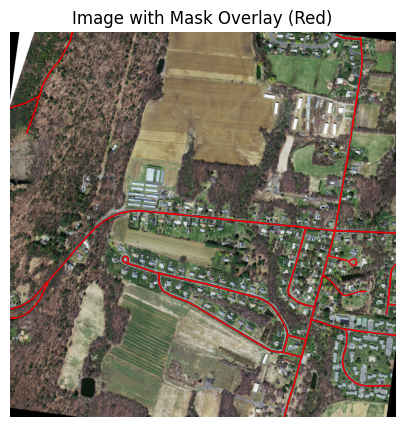

In [116]:
img, mask = dataset.__getitem__(2)

img_np = img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
mask_np = mask.squeeze().cpu().numpy()       # [H, W]

plt.figure(figsize=(10, 5))
plt.imshow(img_np)

mask_overlay = np.zeros((*mask_np.shape, 4))
mask_overlay[mask_np > 0.5] = [1, 0, 0, 1]

plt.imshow(mask_overlay)

plt.title('Image with Mask Overlay (Red)')
plt.axis('off')
plt.show()